In [1]:
import os, time, shutil, logging, random
import pickle, h5py
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader

from sklearn.metrics import *
from hyperopt import *

from utils import *

import warnings
warnings.filterwarnings("ignore")

os.makedirs('./Log', exist_ok=True)
os.makedirs('./Figures', exist_ok=True)

# set random_seed
set_random_seed()
set_torch_benchmark()

In [2]:
device_id, mode, trails_fname, data, use_data_rc_augment = "0", "test", \
"../../nvwa-pse-official/hyper_params_tune/TPE-lr5-epoch10/hyperopt_trails/params.p", \
"../../nvwa-pse-official/data/MCA_pseudocell_bin.mouse_noTestis.h5", \
True

In [3]:
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(filename)s[line:%(lineno)d] %(levelname)s %(message)s',
                    datefmt='%a, %d %b %Y %H:%M:%S',
                    filename=time.strftime('./log_HyperBest.' + mode + '.%m%d.%H:%M:%S.txt'),
                    filemode='w')

## change
os.environ["CUDA_VISIBLE_DEVICES"] = device_id

use_cuda = True
device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")
logging.info(device)


In [4]:
# unpack datasets
species = os.path.basename(data).split('.')[1]
logging.info("#"*60)
logging.info("switching datasets: %s" % species)

# unpack datasets
h5file = h5py.File(data, 'r')
celltype = h5file["celltype"][:]
if mode != "test":
    x_train = h5file["train_data"][:].astype(np.float32)
    y_train_onehot = h5file["train_label"][:].astype(np.float32)
    x_val = h5file["val_data"][:].astype(np.float32)
    y_val_onehot = h5file["val_label"][:].astype(np.float32)

    logging.info(x_train.shape)
    logging.info(x_val.shape)

    logging.info(y_train_onehot.shape)
    logging.info(y_val_onehot.shape)


x_test = h5file["test_data"][:].astype(np.float32)
y_test_onehot = h5file["test_label"][:].astype(np.float32)
test_gene = h5file["test_gene"][:]

logging.info(x_test.shape)
logging.info(y_test_onehot.shape)

h5file.close()


In [5]:
# trails
trials = pickle.load(open(trails_fname, 'rb'))
best = trials.argmin
# params = space_eval(param_space, best)
params = best_params
params['is_spatial_transform'] = False
logging.info(params)


In [6]:
# define datasets parameters
leftpos = int(params['leftpos'])
rightpos = int(params['rightpos'])
logging.info((leftpos, rightpos))

# define hyperparams
output_size = y_test_onehot.shape[-1]
params["output_size"] = output_size

# define dataset params
batch_size = int(params['batchsize'])

logging.debug('\n-----'+'0'+'------\n')
model = get_model(params)
model.Embedding.save(fname="./Log/embedder_init_params.pth")
logging.debug('\n-----'+'1'+'-------\n')
logging.info("weights inited and embedding weights loaded")

model.to(device)
logging.info(model.__str__())

In [7]:
lr = 1e-3
EPOCH = 500

optimizer = Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0,)
# lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=100, factor=0.9)
criterion = nn.BCELoss().to(device)
# criterion = nn.BCEWithLogitsLoss().to(device)
trainer = Trainer(model, criterion, optimizer, device)

logging.debug('\n------'+'2'+'-------\n')
logging.info('\n------'+'train'+'-------\n')


In [8]:
# define train_datasets
if mode != "test":
    x_train = x_train[:, :, leftpos:rightpos]
    x_val = x_val[:, :, leftpos:rightpos]
    logging.info(x_train.shape)
    logging.info(x_val.shape)

    if use_data_rc_augment:
        logging.info("using sequence reverse complement augment...")

        x_train, y_train_onehot = seq_rc_augment(x_train, y_train_onehot)
        logging.info(x_train.shape)

    train_loader = DataLoader(list(zip(x_train, y_train_onehot)), batch_size=batch_size,
                                shuffle=True, num_workers=0, drop_last=False)
    validate_loader = DataLoader(list(zip(x_val, y_val_onehot)), batch_size=32, 
                                shuffle=False, num_workers=0, drop_last=False)

# test_loader
x_test = x_test[:, :, leftpos:rightpos]
logging.info(x_test.shape)

test_loader = DataLoader(list(zip(x_test, y_test_onehot)), batch_size=32, 
                            shuffle=False, num_workers=0, drop_last=False)



In [9]:
if mode == "train" or mode == "resume":
    if mode == "resume":
        model.load_state_dict(torch.load("model.pth"))

    train_loss_list, val_loss_list, test_loss_list = [], [], []
    val_r_list, test_r_list, train_r_list = [], [], []
    lrs = []

    if mode == "resume":
       train_loss_list, val_loss_list, test_loss_list, train_r_list, val_r_list, test_r_list, lrs = pickle.load(open("./chekc_train_log.p", "rb"))
    elif mode == "train":
        logs = [train_loss_list, val_loss_list, test_loss_list, train_r_list, val_r_list, test_r_list, lrs]
        pickle.dump(logs, open("chekc_train_log.p", 'wb'))

    _best_val_loss = np.inf
    _best_val_r = -np.inf
    _best_val_epoch = 0

    # train EPOCH
    for epoch in range(EPOCH):
        # early stop
        if epoch >= _best_val_epoch + 10: #patience_epoch:
            break

        # train
        train_loss = trainer.train_per_epoch(train_loader, epoch, verbose_step=20)
        # _, train_pred_prob, train_target_prob = evaluate(train_loader)

        # fpr, tpr, roc_auc = calculate_roc(train_target_prob, train_pred_prob)
        # roc_l = [roc_auc[k] for k in roc_auc.keys() if roc_auc[k] >=0 and k not in ["macro", "micro"]]
        # train_r = np.mean(roc_l)
        # show_auc_curve(fpr, tpr, roc_auc, output_fname='current_train_roc_curves.pdf')
        train_r = 0.5

        # validation
        val_loss, val_pred_prob, val_target_prob = trainer.evaluate(validate_loader)

        fpr, tpr, roc_auc = calculate_roc(val_target_prob, val_pred_prob)
        roc_l = [roc_auc[k] for k in roc_auc.keys() if roc_auc[k] >=0 and k not in ["macro", "micro"]]
        val_r = np.mean(roc_l)
        show_auc_curve(fpr, tpr, roc_auc, output_fname='current_val_roc_curves.pdf')
        
        # lr_scheduler
        _lr = optimizer.param_groups[0]['lr']
        # lr_scheduler.step(val_loss)

        # test
        test_loss, test_pred_prob, test_target_prob = trainer.evaluate(test_loader)
        
        fpr, tpr, roc_auc = calculate_roc(test_target_prob, test_pred_prob)
        roc_l = [roc_auc[k] for k in roc_auc.keys() if roc_auc[k] >=0 and k not in ["macro", "micro"]]
        test_r = np.mean(roc_l)
        show_auc_curve(fpr, tpr, roc_auc, output_fname='current_test_roc_curves.pdf')
        
        # logs
        logging.info("Train\t Accuracy: %.4f\t Loss: %.4f\t\n" % (train_r, train_loss))
        logging.info("Eval\t Accuracy: %.4f\t Loss: %.4f\t\n" % (val_r, val_loss))

        train_loss_list.append(train_loss); val_loss_list.append(val_loss); test_loss_list.append(test_loss)
        train_r_list.append(train_r); val_r_list.append(val_r); test_r_list.append(test_r)
        lrs.append(_lr) 
        show_train_log(train_loss_list, val_loss_list, val_r_list,
                test_loss_list, test_r_list, lrs, output_fname='current_logs.pdf')
        show_train_log(loss_val=val_loss_list[-20:], output_fname='current_loss_val20.pdf')
        show_train_log(loss_val=val_loss_list, output_fname='current_loss_val.pdf')
        show_train_log(loss_train=train_loss_list, output_fname='current_loss_train.pdf')
        show_train_log(acc_val=train_r_list, output_fname='current_acc_train.pdf')
        show_train_log(acc_val=val_r_list, output_fname='current_acc_val.pdf')
        show_train_log(acc_test=test_r_list, output_fname='current_acc_test.pdf')
        show_train_log(lrs=lrs, output_fname='current_lrs.pdf')

        # get_current_model
        model = trainer.get_current_model()
        # update best
        if val_loss < _best_val_loss or val_r > _best_val_r:
        # if val_r > _best_val_r:
            _best_val_loss = val_loss; _best_val_r = val_r; _best_val_epoch = epoch
            logging.info("Eval\t Best Val Accuracy: %.4f\t Loss: %.4f\t at Epoch: %d\t lr: %.8f\n" % (_best_val_r, _best_val_loss, epoch, _lr))
            logging.info("Eval\t Test Accuracy: %.4f\t Loss: %.4f\n" % (test_r, test_loss))
            show_train_log(train_loss_list, val_loss_list, val_r_list,
                test_loss_list, test_r_list, lrs,  output_fname='current_best_logs.pdf')
            # shutil.copyfile("./Figures/current_train_roc_curves.pdf", "./Figures/best_train_roc_curves.pdf")
            shutil.copyfile("./Figures/current_val_roc_curves.pdf", "./Figures/best_val_roc_curves.pdf")
            shutil.copyfile("./Figures/current_test_roc_curves.pdf", "./Figures/best_test_roc_curves.pdf")
            model.save("best_model.pth")
            
        elif epoch%20 == 1:
            model.save("model.pth")
            logs = [train_loss_list, val_loss_list, test_loss_list, train_r_list, val_r_list, test_r_list, lrs]
            pickle.dump(logs, open("chekc_train_log.p", 'wb'))

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [10]:
show_train_log(loss_val=val_loss_list, output_fname='final_loss_val.pdf')
show_train_log(loss_train=train_loss_list, output_fname='final_loss_train.pdf')
show_train_log(acc_val=train_r_list, output_fname='final_acc_train.pdf')
show_train_log(acc_val=val_r_list, output_fname='final_acc_val.pdf')
show_train_log(acc_test=test_r_list, output_fname='final_acc_test.pdf')
show_train_log(lrs=lrs, output_fname='final_lrs.pdf')

current_r = np.max(test_r_list); current_mse = np.min(test_loss_list)
logging.info(current_r, current_mse)

best_NAS_mse = current_mse; best_NAS_r = current_r
logging.info("\n"+str(model.modules)+'\n'+"mse\t"+str(best_NAS_mse)+"\tR2_score\t"+str(best_NAS_r)+"\n")
fname = time.strftime("./Log/best_model@" + '%m%d_%H:%M:%S')
shutil.copyfile("best_model.pth", fname+".params.pth")
model.load(fname+".params.pth")

logs = [train_loss_list, val_loss_list, test_loss_list, train_r_list, val_r_list, test_r_list, lrs]
pickle.dump(logs, open(fname+".train_log.p", 'wb'))
logging.info("update best NAS")
logging.info(best_NAS_r)
logging.info(best_NAS_mse)

--- Logging error ---
Traceback (most recent call last):
  File "/home/ggj/anaconda3/envs/pytorch-cuda/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/home/ggj/anaconda3/envs/pytorch-cuda/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/home/ggj/anaconda3/envs/pytorch-cuda/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/home/ggj/anaconda3/envs/pytorch-cuda/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/home/ggj/anaconda3/envs/pytorch-cuda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ggj/anaconda3/envs/pytorch-cuda/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ggj/anaconda3/envs/pytorch-cuda/lib/python3.7/site-packages/ipyk

In [12]:
os.makedirs("./Test", exist_ok=True)

model.load_state_dict(torch.load("./best_model.pth"))
model.to(device)
model.eval()

test_target_l, test_pred_l, test_roc_l = [], [], []
# test for 20 times
for idx in range(20):
    # test
    test_loss, test_pred_prob, test_target_prob = trainer.evaluate(test_loader)

    fpr, tpr, roc_auc = calculate_roc(test_target_prob, test_pred_prob)
    roc_l = [roc_auc[k] for k in roc_auc.keys() if roc_auc[k] >=0 and k not in ["macro", "micro"]]
    test_r = np.mean(roc_l)
    show_auc_curve(fpr, tpr, roc_auc, output_dir='./Test', output_fname='test_'+str(idx)+'_mode_roc_curves.pdf')

    # pd.DataFrame(test_target_prob, columns=celltype).to_csv("./Test/test_"+str(idx)+"_mode_target_prob.csv")
    pd.DataFrame(test_pred_prob, columns=celltype, index=test_gene).to_csv("./Test/test_"+str(idx)+"_mode_pred_prob.csv")

    test_target_l.append(test_target_prob)
    test_pred_l.append(test_pred_prob)
    test_roc_l.append(roc_l)

test_target = np.array(test_target_l).mean(0)
test_pred = np.array(test_pred_l).mean(0)
test_roc = np.array(test_roc_l).mean(0)

logging.info(test_target.shape)
logging.info(test_roc.shape)

pd.DataFrame(test_target, columns=celltype, index=test_gene).to_csv("./Test/test_target_prob.csv")
pd.DataFrame(test_pred, columns=celltype, index=test_gene).to_csv("./Test/test_mode_pred_prob.csv")
pd.DataFrame(test_roc, index=celltype).to_csv("./Test/test_mode_roc.csv")

logging.info("Test finished.")


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

## explainer

In [9]:
from explainer import *
os.makedirs("Motif", exist_ok=True)

In [10]:
model.load_state_dict(torch.load("./Log/best_model@1016_12:42:48.params.pth", map_location=device))
# model.Embedding.load_state_dict(torch.load("./Log/embedder_init_params.pth"))
model.to(device)
model.eval()

Net(
  (Embedding): CNN(
    (conv1): Sequential(
      (conv): Conv1d(4, 64, kernel_size=(7,), stride=(1,))
      (activate): ReLU()
      (pool): AvgPool1d(kernel_size=(7,), stride=(7,), padding=(0,))
    )
    (conv2): Sequential(
      (conv): Conv1d(64, 128, kernel_size=(7,), stride=(1,), dilation=(2,))
      (activate): ReLU()
      (pool): AvgPool1d(kernel_size=(7,), stride=(7,), padding=(0,))
    )
    (conv3): Sequential(
      (conv): Conv1d(128, 512, kernel_size=(9,), stride=(1,), dilation=(3,))
      (activate): ReLU()
      (pool): AvgPool1d(kernel_size=(9,), stride=(9,), padding=(0,))
    )
    (globalpooling): AdaptiveAvgPool1d(output_size=8)
  )
  (MLP): MLP(
    (fc1): Sequential(
      (0): Linear(in_features=4096, out_features=2048, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.7)
    )
    (fc2): Sequential(
      (0): Linear(in_features=2048, out_features=2048, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5)
    )
    (fc3): Sequential(
      (0): Line

# get motif
## convolution layer 1

In [138]:
fmap1, X1 = get_fmap(model, model.Embedding.conv1[0], test_loader)
fmap1.shape, X1.shape

((2000, 64, 9994), (2000, 4, 10000))

In [143]:
W1_new = get_activate_seq_from_fmap(fmap1, X1, pool=1, threshold=0.9, motif_width=8)
W1.shape

(64, 4, 10)

In [140]:
meme_generate(W1, output_file="./Motif/meme_conv1_new.txt")

In [149]:
filter_heatmap_W(W1_new, factor=None, fig_size=(10,4), save=True)

In [16]:
out_fname = "./Motif/test_gene_activate_conv1.fasta"
gene_seq, gene_name = get_activate_sequence_from_fmap(fmap1, X1, pool=1, threshold=0.999, motif_width=20)
onehot2seq(gene_seq, gene_name, out_fname)

## convolution layer 2

In [145]:
fmap2, X2 = get_fmap(model, model.Embedding.conv2[1], test_loader)
fmap2.shape, X2.shape

((2000, 128, 1415), (2000, 4, 10000))

In [146]:
fmap1, _ = get_fmap(model, model.Embedding.conv1[2], test_loader)
fmap1.shape

(2000, 64, 1427)

In [147]:
W2 = get_activate_seq_from_fmap(fmap2, fmap1, threshold=0.9, motif_width=7)
W2.shape

(128, 64, 9)

In [87]:
W2 = get_activate_seq(model, model.Embedding.conv2[0], test_loader, pool=7, threshold=0.99, motif_width=10)
W2.shape

(128, 4, 70)

In [89]:
meme_generate(W2, output_file="./Motif/meme_conv2.txt")

In [90]:
out_fname = "./Motif/test_gene_activate_conv2.fasta"
save_activate_sequence(model, model.Embedding.conv2[0], test_loader, out_fname, pool=7)

## convolution layer 3

In [156]:
fmap3, X3 = get_fmap(model, model.Embedding.conv3[0], test_loader)
fmap3.shape, X3.shape

((2000, 512, 178), (2000, 4, 10000))

In [92]:
fmap2, _ = get_fmap(model, model.Embedding.conv2[2], test_loader)
fmap2.shape

(2000, 128, 202)

In [93]:
W3 = get_activate_seq_from_fmap(fmap3, fmap2, threshold=0.999, motif_width=10)
W3.shape

(512, 128, 10)

In [104]:
filter_heatmap_W(W3, factor=None, fig_size=(4, 25), save=True)

In [97]:
W3 = get_activate_seq(model, model.Embedding.conv3[0], test_loader, pool=7*7, threshold=0.90, motif_width=10)

In [98]:
meme_generate(W3, output_file="./Motif/meme_conv3.txt")

In [99]:
out_fname = "./Motif/test_gene_activate_conv3.fasta"
save_activate_sequence(model, model.Embedding.conv3[0], test_loader, out_fname, pool=7*7)

# analyse motif frequency

In [166]:
W1_freq = calc_frequency_W(W1, background=0.25)
W2_freq = calc_frequency_W(W2, background=0.25)
W3_freq = calc_frequency_W(W3, background=0.25)

# tsne-dense 

In [160]:
fmap_dense, _ = get_fmap(model, model.MLP.fc3[2], test_loader)
fmap_dense.shape

(2000, 2048)

In [161]:
from sklearn.manifold import TSNE

In [162]:
fmap_emb = TSNE(n_components=2).fit_transform(fmap_dense)
fmap_emb.shape

(2000, 2)

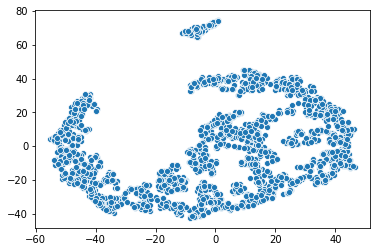

In [164]:
sns.scatterplot(x=fmap_emb[:,0], y=fmap_emb[:,1])

# saliancy score

In [73]:
input_tensor = torch.from_numpy(x_test[:128, :, 6500:13500]).to(device)
input_tensor.shape

torch.Size([128, 4, 7000])

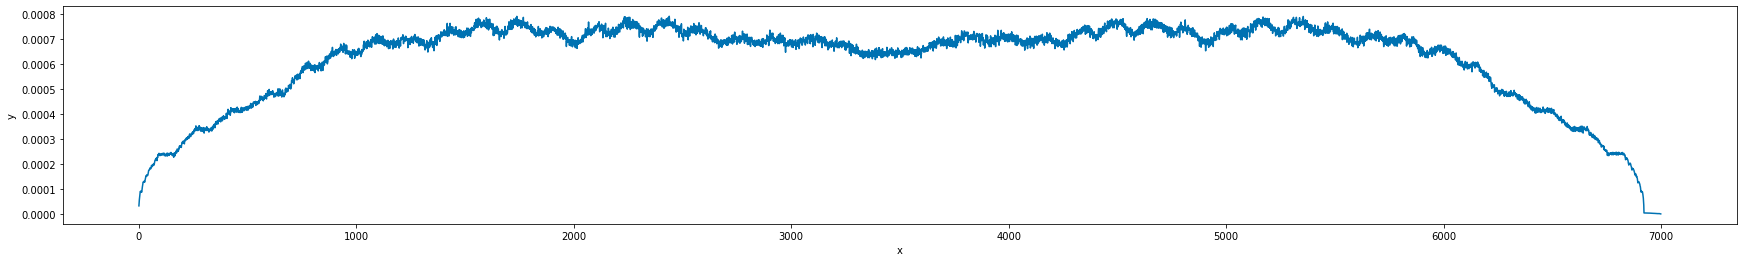

In [74]:
plot_saliancy_location(model_init, input_tensor, n_class=10)

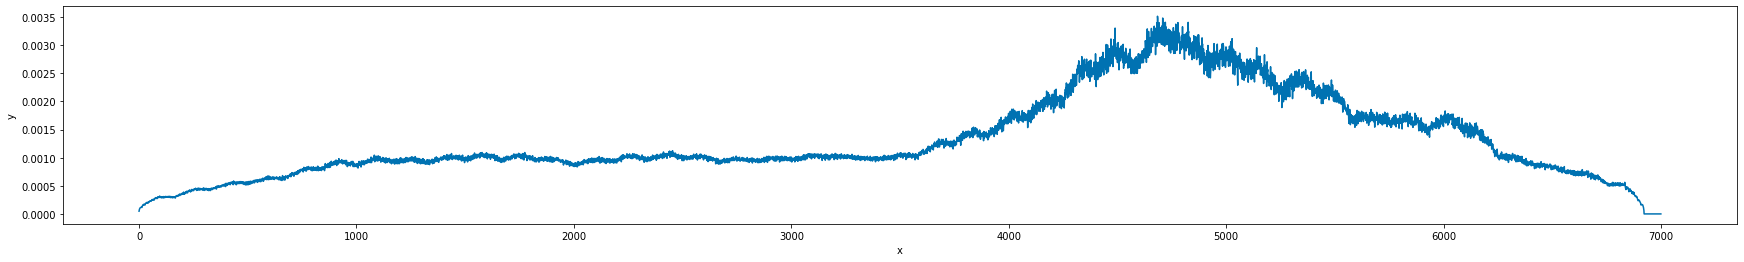

In [75]:
plot_saliancy_location(model, input_tensor, n_class=10)

# layer conductance

In [38]:
df_conv1 = label_neuron_importance(model, model.Embedding.conv1[0], input_tensor, label=celltype)

In [51]:
plt.figure(figsize=(30,100))
ax = sns.heatmap(df_conv1, cmap="vlag")
plt.savefig("./Motif_layer_conductance/importance_conv1_large.pdf")
plt.close()

In [41]:
df_conv2 = label_neuron_importance(model, model.Embedding.conv2[0], input_tensor, label=celltype)

In [52]:
plt.figure(figsize=(40,100))
ax = sns.heatmap(df_conv2, cmap="vlag")
plt.savefig("./Motif_layer_conductance/importance_conv2_large.pdf")
plt.close()

In [40]:
df_conv3 = label_neuron_importance(model, model.Embedding.conv3[0], input_tensor, label=celltype)

In [49]:
plt.figure(figsize=(50,100))
ax = sns.heatmap(df_conv3, cmap="vlag")
plt.savefig("./Motif_layer_conductance/importance_conv3_large.pdf")
plt.close()

In [ ]:
df_conv1.to_csv("./Motif/importance_conv1.csv")
df_conv2.to_csv("./Motif/importance_conv2.csv")
df_conv3.to_csv("./Motif/importance_conv3.csv")